In [1]:
# 神经网络ANN
'''
conda create -n myenv python=3.8
conda activate myenv

conda install numpy pandas scikit-learn
conda install -c conda-forge tensorflow
'''
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

In [2]:

# Load the data
df = pd.read_csv('clark-y-2.csv')

# Filter the data
filtered_df = df[
    (df['Reynold'] >= 0.1e5) & (df['Reynold'] <= 40e5) &  # 雷诺数范围
    (df['Mach'] >= 0.1) & (df['Mach'] <= 0.7) &            # 马赫数范围
    (df['Alpha'] >= -3) & (df['Alpha'] <= 15)              # 迎角范围
]

# Split the data into inputs (X) and outputs (y)
X = filtered_df[['Reynold', 'Mach', 'Alpha']].values
y = filtered_df[['cl', 'cd', 'cm']].values


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 29)

In [4]:
# Normalize the input data
scaler = MinMaxScaler()
scalery = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scalery.fit_transform(y_train)
y_test = scalery.transform(y_test)

# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='linear')  # 3 outputs: cl, cd, cm
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# Train the model
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test,y_test), callbacks=[early_stop])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {loss}, MAE: {mae}")

# CNN2: Loss: 0.0032769939862191677, MAE: 0.038386013358831406
# CNN3: Loss: 0.0012407711474224925, MAE: 0.025044899433851242
# CNN4: Loss: 0.0007000479381531477, MAE: 0.017104944214224815
# CNN5: Loss: 0.0006939252489246428, MAE: 0.016976164653897285
# CNN6: Loss: 0.0005698658060282469, MAE: 0.01500221062451601

# R2-score
y_pred = model.predict(X_test)
y_pred = scalery.inverse_transform(y_pred)
y_test = scalery.inverse_transform(y_test)
r2_scores = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
for i, r2 in enumerate(r2_scores):
    print(f"R² score for output {i+1}: {r2}")

Epoch 1/1000
125/125 [==============================] - 1s 5ms/step - loss: 1.0759 - mae: 0.7991 - val_loss: 1.0129 - val_mae: 0.7935
Epoch 2/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.8797 - mae: 0.7297 - val_loss: 0.7064 - val_mae: 0.6165
Epoch 3/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.5480 - mae: 0.5153 - val_loss: 0.4774 - val_mae: 0.4449
Epoch 4/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.4137 - mae: 0.4077 - val_loss: 0.3988 - val_mae: 0.3924
Epoch 5/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.3564 - mae: 0.3668 - val_loss: 0.3565 - val_mae: 0.3556
Epoch 6/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.3224 - mae: 0.3390 - val_loss: 0.3246 - val_mae: 0.3330
Epoch 7/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.2976 - mae: 0.3185 - val_loss: 0.2985 - val_mae: 0.3142
Epoch 8/1000
125/125 [==============================] - 0s 2ms

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 3)                 27        
                                                                 
Total params: 11,539
Trainable params: 11,539
Non-traina

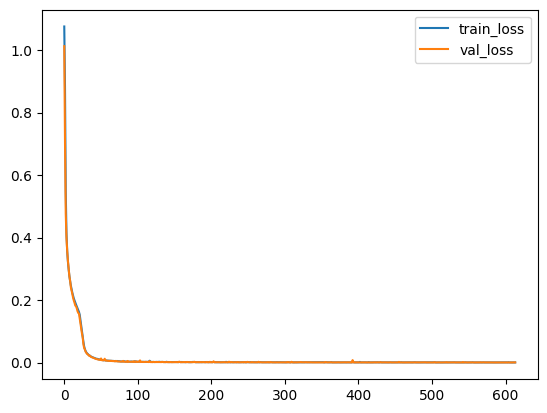

In [6]:
# plot the loss curve
losses = pd.DataFrame(history.history)
plt.plot(losses.index, losses['loss'], label='train_loss')
plt.plot(losses.index, losses['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [7]:
# Save the entire model to a file
model.save('clark-y-cnn.h5')

4/4 [==============================] - 0s 25ms/step


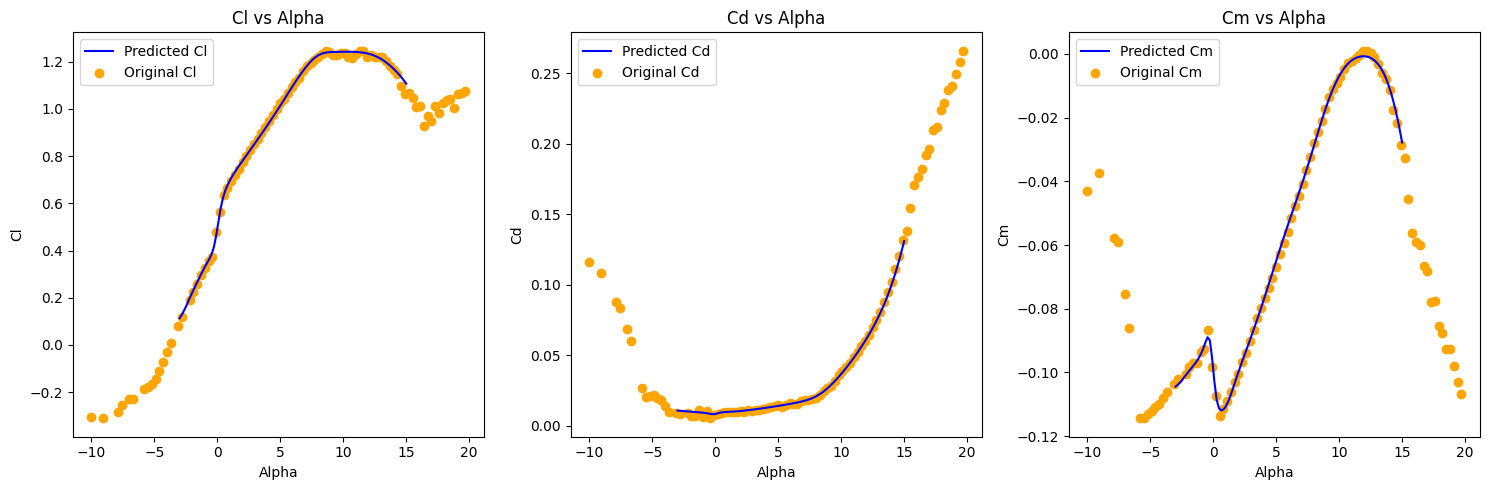